In [192]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
from keras.layers import Input, Dense, LSTM, Embedding, Concatenate, TimeDistributed, Bidirectional
from attention import AttentionLayer
import warnings

pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings('ignore')


In [193]:
df= pd.read_csv(r"D:\Datasets\Text trans- Attention Mech\Amazon Reviews\Reviews.csv")

##### This dataset consists of reviews of fine foods from Amazon. The data spans a period of more than 10 years, including all ~500,000 reviews up to October 2012. These reviews include product and user information, ratings, plain text review, and summary. It also includes reviews from all other Amazon categories.

In [194]:
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [195]:
df['Summary'][0]

'Good Quality Dog Food'

In [196]:
df['Text'][0]

'I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.'

In [197]:
df.shape

(568454, 10)

In [198]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [199]:
# We are just intrested in the two columns that is "Summary" and "Text", and will discard other columns
new_df= df[['Summary','Text']]

In [200]:
new_df.head()

,Summary,Text
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ..."
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal."


In [201]:
new_df.shape

(568454, 2)

In [202]:
# WE have a very large dataset, so we will only take 100000 samples  to reduce the computation time

new_df= new_df[0:100000]

In [203]:
new_df.shape

(100000, 2)

### Check the Duplicate and NA rows in Text columns

In [204]:
new_df['Text'].unique().shape

(88426,)

In [205]:
new_df.isna().sum()

Summary    2
Text       0
dtype: int64

In [206]:
# we will drop the duplicate rows and NA values

new_df.drop_duplicates(subset= 'Text', inplace= True)  # droping duplicates
new_df.dropna(axis= 0, inplace= True)        # droping NA

In [207]:
new_df.shape

(88425, 2)

### Preprocessing

In [208]:
# Dictionary that we will use for expanding contractions

contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",

                           "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",

                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",

                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",

                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",

                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",

                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",

                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",

                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",

                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",

                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",

                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",

                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",

                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",

                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",

                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",

                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",

                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",

                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",

                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",

                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",

                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",

                           "you're": "you are", "you've": "you have"}

#### We will perform seprate text preprocessing for Reviews and Text Summarization

### a) Text / Reviews Cleaning

In [209]:
# let's peak at the text data
new_df['Text'][:10]

0    I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...
1             Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
2    This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...
3    If you are looking for the secret ingredient in Robitussin I believe I have found it.  I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda.  The fl...
4                                                               Great taffy at a great price.  There was a wide assortment of yummy taffy.  Delivery was very quick.  If your a taff

##### We will perform the below preprocessing tasks for our data:

Convert everything to lowercase

Remove HTML tags

Contraction mapping

Remove (‘s)

Remove any text inside the parenthesis ( )

Eliminate punctuations and special characters

Remove stopwords

Remove short words


In [210]:
# Text Preprocessing for Text Reviews Column

def review_cleaning(text):
    
    # convert the text into lower case
    new_text= text.lower()
    # remove html tags if any
    new_text = BeautifulSoup(new_text, 'lxml').text
    # contraction mapping
    new_text= ' '.join([contraction_mapping[txt] if txt in contraction_mapping else txt for txt in new_text.split(" ")])
    # replace "" to empty space
    new_text= re.sub('"', '', new_text)
    # remove 's
    new_text= re.sub('\'s', '', new_text)
    # remove any text inside the paranthesis
    new_text= re.sub(r'\([^)]*\)', '', new_text)
    # keep only alphabets, discard anything else
    new_text= re.sub('[^a-zA-Z]', ' ', new_text)
    # remove stopwords
    new_text= [txt for txt in new_text.split() if txt not in stopwords.words('english')]
    
    # remove short words
    longwords= []
    for i in new_text:
        if len(i) >= 3:
            longwords.append(i)
#     print((' '.join(longwords)))
    return (' '.join(longwords)).strip()
            
    

In [211]:
cleaned_txt= []

for txt in new_df['Text']:
    cleaned_txt.append(review_cleaning(txt))

In [212]:
review_cleaning("Remove (short""" "should's is the words")

'remove shortshould words'

### Summary Cleaning

In [213]:
new_df['Summary'][:10]

0                            Good Quality Dog Food
1                                Not as Advertised
2                            "Delight" says it all
3                                   Cough Medicine
4                                      Great taffy
5                                       Nice Taffy
6    Great!  Just as good as the expensive brands!
7                           Wonderful, tasty taffy
8                                       Yay Barley
9                                 Healthy Dog Food
Name: Summary, dtype: object

In [214]:
def Summary_cleaning(text):
    
    # convert the text into lower case
    new_txt= text.lower()
    # contraction mapping
    new_txt= ' '.join([contraction_mapping[txt] if txt in contraction_mapping else txt for txt in new_txt.split()])
    # remove 's
    new_txt= re.sub('\'s', '', new_txt)
    # only have aplhabets
    new_txt= re.sub('[^a-zA-Z]', ' ', new_txt)
    
    # create tokens by splitting
    tokens= new_txt.split()
    
    new_string= ''
#     print(tokens)
    
    for i in tokens:
#         print(i)
        if len(i) > 1:
            new_string= new_string + i + ' '
    return new_string          

In [215]:
# call above function

cleaned_summary= []
for txt in new_df['Summary']:
    cleaned_summary.append(Summary_cleaning(txt))
    

In [216]:
cleaned_summary[:5]

['good quality dog food ',
 'not as advertised ',
 'delight says it all ',
 'cough medicine ',
 'great taffy ']

In [217]:
# create new columns for cleaned text and summary

new_df['cleaned_text']= cleaned_txt
new_df['cleaned_summary']= cleaned_summary


In [218]:
new_df.head()

,Summary,Text,cleaned_text,cleaned_summary
0,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labr...,bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better,good quality dog food
1,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo"".",product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo,not as advertised
2,"""Delight"" says it all","This is a confection that has been around a few centuries. It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with ...",confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat famil...,delight says it all
3,Cough Medicine,If you are looking for the secret ingredient in Robitussin I believe I have found it. I got this in addition to the Root Beer Extract I ordered (which was good) and made some cherry soda. The fl...,looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal,cough medicine
4,Great taffy,"Great taffy at a great price. There was a wide assortment of yummy taffy. Delivery was very quick. If your a taffy lover, this is a deal.",great taffy great price wide assortment yummy taffy delivery quick taffy lover deal,great taffy


In [219]:
li= []
for i in new_df['Summary']:
    if len(i)<=1:
        li.append(i)
        print([i]) 
len(li)

['K']
['Q']


2

In [220]:
len(new_df['cleaned_summary'])

88425

In [221]:
new_df['cleaned_summary'].isna().sum()

0

In [222]:
new_df[new_df['cleaned_summary'].isnull()]

,Summary,Text,cleaned_text,cleaned_summary


In [223]:
# replace empty places with nan and then drop the Nan's
new_df['cleaned_summary'].replace('', np.nan, inplace= True)
new_df.dropna(axis= 0, inplace= True)

In [224]:
new_df['cleaned_summary'].shape

(88356,)

In [225]:
# Add START and END special tokens at the start and end of the summary

new_df['cleaned_summary']= new_df['cleaned_summary'].apply(lambda x: '_START_' + x +'_END_')

In [226]:
# Let's peak at the first 5 processed text and clean summary

for i in range(5):
    print(new_df['cleaned_text'][i])
    print(new_df['cleaned_summary'][i])
    print('\n')
    

bought several vitality canned dog food products found good quality product looks like stew processed meat smells better labrador finicky appreciates product better
_START_good quality dog food _END_


product arrived labeled jumbo salted peanuts peanuts actually small sized unsalted sure error vendor intended represent product jumbo
_START_not as advertised _END_


confection around centuries light pillowy citrus gelatin nuts case filberts cut tiny squares liberally coated powdered sugar tiny mouthful heaven chewy flavorful highly recommend yummy treat familiar story lewis lion witch wardrobe treat seduces edmund selling brother sisters witch
_START_delight says it all _END_


looking secret ingredient robitussin believe found got addition root beer extract ordered made cherry soda flavor medicinal
_START_cough medicine _END_


great taffy great price wide assortment yummy taffy delivery quick taffy lover deal
_START_great taffy _END_




### Understanding the distibution of the sequences

In [227]:
text_word_count= []
summary_word_count= []

# check the length of the texts and store the count 
for i in new_df['cleaned_text']:
    
    text_word_count.append(len(i.split()))
    
# check the length of the summary and store the count 
for i in new_df['cleaned_summary']:
    summary_word_count.append(len(i.split()))
    

# lets creata a dataframe for the count of length

length_df= pd.DataFrame({'text': text_word_count, 'summary': summary_word_count})
length_df

,text,summary
0,23,5
1,18,4
2,39,5
3,17,3
4,13,3
...,...,...
88351,7,2
88352,91,4
88353,20,3
88354,28,2


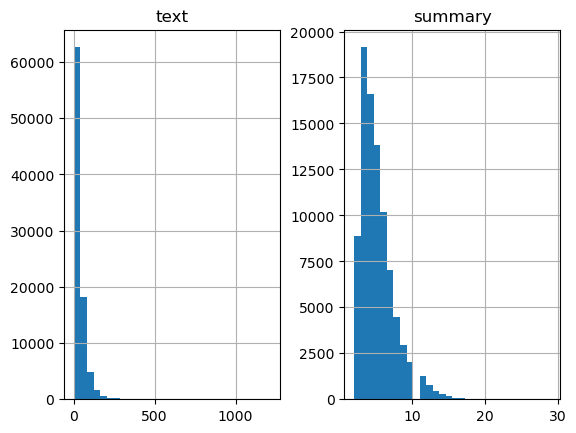

In [228]:
# lets visualize it on a histogram 
length_df.hist(bins= 30)
plt.show()

In [229]:
# check what is the max length of sentence in text and in summary
max(length_df['text']), max(length_df['summary'])

(1212, 29)

In [230]:
max_len_text= 80
max_len_summary= 10 

### Split Train and Test Data

In [231]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(new_df['cleaned_text'], new_df['cleaned_summary'], test_size= 0.1, random_state= 0, shuffle= True)

X_train.shape,  y_train.shape, X_val.shape, y_val.shape

((79520,), (79520,), (8836,), (8836,))

In [232]:
X_train.head()

3256                                                                                   item awesome chocolate flavor would recommend product anyone looking hot chocolate keurig machine uses cups great product
48474                                                                                      really enjoyed cereal bar banana nut bread flavor tasted authentic like banana flavoring moist dense around great bar
92377                           coffee bolder expected expecting nice medium roast blend flavor bolder stronger even brewing cups pod smells awesome package brewing pods fit keurig perfectly use reorder blend
29078    second flavor izze tried first clementine tasty syrupy really enjoyed flavor tried blackberry unlike clementine flavor name drink also makes one juices used make beverage blackberry like clementin...
15364    agree review beware plant pictured anything like purchased desert rose dad fell love one photo description amazon shipping weight says lbs mine ups lbs tot

In [233]:
y_train.head()

3256                                _START_love this _END_
48474               _START_great on the go breakfast _END_
92377                    _START_bolder than expected _END_
29078    _START_another flavor and another thumbs up _END_
15364    _START_not as pictured at all false listing _END_
Name: cleaned_summary, dtype: object

### Prepare Tokenizer

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence.

#### a) Text Tokenizer

In [234]:
# prepare tokenizer for reviews on training data

text_tokenizer= Tokenizer()
text_tokenizer.fit_on_texts(list(X_train))

# convert text seq into integer seq
X_train= text_tokenizer.texts_to_sequences(X_train)
X_val= text_tokenizer.texts_to_sequences(X_val)


# padding zero upto maximum length
X_train= pad_sequences(X_train, maxlen= max_len_text, padding= 'post')
X_val= pad_sequences(X_val, maxlen= max_len_text, padding= 'post')

X_voc_size= len(text_tokenizer.word_index) + 1

X_voc_size

51825

In [235]:
X_train[0]

array([243, 429,  27,   8,   5,  60,   7, 333, 132,  72,  27, 357, 393,
       797, 155,   6,   7,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0])

### b) Summary Tokenizer

In [236]:
# preparing tokenixer for Summary columns
summary_tokenizer= Tokenizer()
summary_tokenizer.fit_on_texts(list(y_train))

y_train= summary_tokenizer.texts_to_sequences(y_train)
y_val= summary_tokenizer.texts_to_sequences(y_val)


# padding zero upto max length
y_train= pad_sequences(y_train, maxlen= max_len_summary, padding= 'post')
y_val= pad_sequences(y_val, maxlen= max_len_summary, padding= 'post')

y_voc_size= len(summary_tokenizer.word_index) + 1
y_voc_size

14068

### Model Building


Return Sequences = True: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

Return State = True: When return state = True, LSTM produces the hidden state and cell state of the last timestep only.

Initial State: This is used to initialize the internal states of the LSTM for the first timestep.

Stacked LSTM: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. I encourage you to experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)


In [237]:
# Building a 3 stacked LSTM for encoder
from keras import backend as backend

# Resets all state generated by Keras
backend.clear_session()
latent_dim= 500

# Encoder
encoder_inputs= Input(shape= (max_len_text,))
enc_emb= Embedding(X_voc_size, latent_dim, trainable= True)(encoder_inputs)

# LSTM 1
# this line of code mean creating LSTM with 100(latent_dim) cell/neuron with each cell/neuron has its 
# own forget gate input gate and output gate
encoder_lstm1= LSTM(latent_dim, return_sequences= True, return_state= True)
encoder_output1, state_h1, state_c1= encoder_lstm1(enc_emb)

# LSTM 2
encoder_lstm2= LSTM(latent_dim, return_sequences= True, return_state= True)
encoder_output2, state_h2, state_c2= encoder_lstm2(encoder_output1)

# LSTM 3
encoder_lstm3= LSTM(latent_dim, return_sequences= True, return_state= True)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

#------------------------- Setting Up Decoder------------------------------
# decoder
decoder_inputs= Input(shape= (None, ))
dec_emb= Embedding(y_voc_size, latent_dim, trainable=  True)(decoder_inputs)

# LSTM using encoder_states as initial state
decoder_lstm= LSTM(latent_dim, return_sequences= True, return_state= True)
decoder_outputs, deocder_fwd_state, decoder_back_state= decoder_lstm(dec_emb, initial_state= [state_h, state_c])


# Attention Layer
attn_layer= AttentionLayer(name= 'attention_layer')
attn_out, attn_states= attn_layer([encoder_outputs, decoder_outputs])

# Concatenate attention output and decoder output
decoder_concat_input= Concatenate(axis= -1, name= 'concat_layer')([decoder_outputs, attn_out])

# Dense Layer
decoder_dense= TimeDistributed(Dense(y_voc_size, activation= 'softmax'))
decoder_outputs= decoder_dense(decoder_concat_input)

# Define the Model
model= Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 80)]                 0         []                            
                                                                                                  
 embedding (Embedding)       (None, 80, 500)              2591250   ['input_1[0][0]']             
                                                          0                                       
                                                                                                  
 lstm (LSTM)                 [(None, 80, 500),            2002000   ['embedding[0][0]']           
                              (None, 500),                                                        
                              (None, 500)]                                                    

##### Using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [238]:
# compile the model
model.compile(optimizer= 'rmsprop', loss='sparse_categorical_crossentropy')

In [239]:
# In `min` mode, training will stop when the quantity monitored has stopped decreasing
es= EarlyStopping(monitor= 'val_loss', mode= min, verbose= 1)

In [253]:
y_train

array([[   1,   13,   15, ...,    0,    0,    0],
       [   1,    3,   42, ...,    0,    0,    0],
       [   1, 4545,   54, ...,    0,    0,    0],
       ...,
       [   1,  121,    6, ...,    0,    0,    0],
       [   1, 1167,  172, ...,    0,    0,    0],
       [   1,    5,   20, ...,    2,    0,    0]])

In [261]:
# history=model.fit([x_tr,y_tr[:,:-1]], y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,epochs=50,callbacks=[es],batch_size=512, validation_data=([x_val,y_val[:,:-1]], y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:,:][0]

array([[ 1],
       [13],
       [15],
       [ 2],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0],
       [ 0]])

In [242]:
y_train.shape

(79520, 10)

In [248]:
y_train[:,:-1][0]

array([ 1, 13, 15,  2,  0,  0,  0,  0,  0])

In [ ]:
# we will train the model on a batch size of 512, and validate on hold out set
# ([encoder_input, decoder_input], decoder_output)
history= model.fit([X_train, y_train[:, :-1]], y_train.reshape(y_train.shape[0], y_train.shape[1], 1)[:, 1:], batch_size= 512, epochs= 50, callbacks= [es], validation_data=([X_val, y_val[:, :-1]], y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:, 1:]))


Epoch 1/50

156/156 [==============================] - 1542s 10s/step - loss: 3.5855 - val_loss: 3.0297
Epoch 2/50
 12/156 [=>............................] - ETA: 22:39 - loss: 3.0855

In [ ]:
# Understanding diagnostic plot
plt.plot(history.history['loss'], label= 'train')
plt.plot(history.history['val_loss'], label= 'test')
plt.legend()
plt.show()

In [ ]:
# Build the dict to convert the index to words for target and source vocabulary

reverse_target_word_index= decoder_tokenixer.index_word
reverse_source_word_index= encoder_tokenizer.index_word
target_word_index= decoder_tokenizer.word_index

In [ ]:
reverse_target_word_index

In [ ]:
reverse_source_word_index

In [ ]:
target_word_index

## Inference

In [ ]:
# encoder inference
encoder_model= Model(inputs= encoder_inputs, outputs= [encoder_outputs, state_h, state_c])


# decoder inference
# below tensors will hold the states of the previous timestep
decoder_state_input_h= Input(state= (latent_dim,))
decoder_state_input_c= Input(state= (latent_dim,))
decoder_hidden_state_input= Input(state= (max_len_text, latent_dim))

# Get the embeddings of the decoder seq
decoder_model= dec_emb(decoder_input)


# to predict the next word in the seq, set the initial states to the states from the previous time step
decoder_output2, state_h2, state_c2= decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# attention inference
attn_out_inf, attn_state_inf= attn_layer([decoder_hidden_state_input, decoder_output2])
decoder_inf_concat= Concatenate(axis= -1, name= 'concat')([decoder_output2, attn_out_inf])

# A dense softmax layer to generate prob dist. over the target vocabulary
decoder_output2= decoder_dense(decoder_inf_concat)


# Final decoder model
decoder_model= Model(
[decoder_inputs] + [decoder_hidden_state_input, decoder_state_input_h, decoder_state_input_c],
[decoder_outputs2] + [state_h2, state_c2])


In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))

    # Chose the 'start' word as the first word of the target sequence
    target_seq[0, 0] = target_word_index['start']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]

        if(sampled_token!='end'):
            decoded_sentence += ' '+sampled_token

            # Exit condition: either hit max length or find stop word.
            if (sampled_token == 'end' or len(decoded_sentence.split()) >= (max_len_summary-1)):
                stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def seq2summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['start']) and i!=target_word_index['end']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def seq2text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

In [ ]:
for i in range(len(x_val)):
    print("Review:",seq2text(x_val[i]))
    print("Original summary:",seq2summary(y_val[i]))
    print("Predicted summary:",decode_sequence(x_val[i].reshape(1,max_len_text)))
    print("\n")